# ES170 Final Project
Author: Abdulrahman Jamjoom

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qiskit.tools.visualization import plot_histogram
from scipy.linalg import hadamard
from math import *
import Qconfig
import sys
from qiskit import QuantumProgram, QuantumCircuit
from qiskit.tools import visualization
import random
import operator
from IBMQuantumExperience.IBMQuantumExperience import IBMQuantumExperience

api = IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)

# Quantum search of a real unstructred database

Creating a dynamic Uf gate for Grover's algorithm

Grover for 2 qubits, searching array [3,2,1,0]

Theoretical Source: https://arxiv.org/pdf/1502.04943.pdf

In [117]:
# Circuit for two bits
def grover(search_val):
    
    iterations = 3

    qp_uf = QuantumProgram()
    qp_uf.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url

    n = 10  # number of qubits
    q = qp_uf.create_quantum_register("q", n) # quantum register
    c = qp_uf.create_classical_register("c", n) # classical register

    grove = qp_uf.create_circuit("grove", [q], [c])

    #####################
    # Init Qubits
    #####################

    grove.h(q[0]) # x_1
    grove.h(q[1]) # x_2

    grove.x(q[8]) 

    # Set search phrase
    bit_pattern = int('{00:b}'.format(search_val))
            
    if bit_pattern == 11:
        grove.x(q[4])
        grove.x(q[5])
    elif bit_pattern == 10:
        grove.x(q[4])
    elif bit_pattern == 1:
        grove.x(q[5])

    grove.x(q[6])
    grove.h(q[6]) # hadamard last qubit

    for i in range(iterations):
        #####################
        # Grover Iteration
        #####################

        #####################
        # Uw's Implementation
        #####################

        ##########
        # Memory
        ##########

        # Toffoli gates 1
        grove.x(q[0]) 
        grove.x(q[1])
        grove.ccx(q[0],q[1],q[2])
        grove.ccx(q[0],q[1],q[3])
        grove.x(q[0]) 
        grove.x(q[1])

        # Toffoli gates 2
        grove.x(q[1])
        grove.ccx(q[0],q[1],q[3])
        grove.x(q[1])
        
        # Toffoli gates 3
        grove.x(q[0])
        grove.ccx(q[0],q[1],q[2])
        grove.x(q[0])

        # Toffoli gates 4

        ##########5
        # Oracle Function
        ##########

        # flipping control cubit every iteration of oracle function (to load twice for uncomputation for q[2], q[3])
        grove.cx(q[8], q[7])

        # cnot (comparing loaded data and search phrase)
        grove.cx(q[2],q[4])
        grove.cx(q[3],q[5])

        # negative controls
        grove.x(q[4])
        grove.x(q[5])

        # toffoli gate with 3 controls using ancila bits and uncomputation
        grove.ccx(q[4], q[5], q[9])
        grove.ccx(q[7], q[9], q[6])
        grove.ccx(q[4], q[5], q[9])

        # restore the negative controls
        grove.x(q[4])
        grove.x(q[5])

        # uncomputation of the search phrase
        grove.cx(q[2],q[4])
        grove.cx(q[3],q[5])

        ## END of Uw 

        ##########
        # Grover's diffusion operator
        ##########

        grove.h(q[0])
        grove.h(q[1])

        grove.x(q[0])
        grove.x(q[1])

        grove.cz(q[0], q[1])

        grove.x(q[0])
        grove.x(q[1])

        grove.h(q[0])
        grove.h(q[1])

    #############
    # Measurement
    #############

    grove.measure(q[0], c[0])
    grove.measure(q[1], c[1])
    print("gate size ", len(grove.data))
    

    #####################
    # Execute & Results
    #####################

    backend = 'ibmqx_hpc_qasm_simulator'
    #backend = 'ibmqx4'   
    circuits = ['grove']  
    shots = 1024           
    max_credits = 3          
    wait = 10   
    timeout = 240 
    result_real = qp_uf.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
    plot_histogram(result_real.get_counts('grove'))


gate size  107


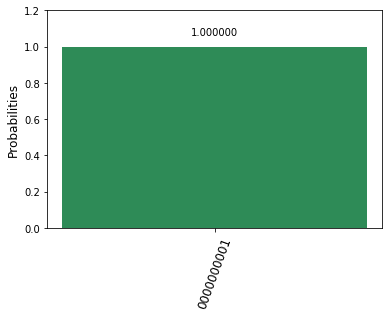

In [118]:
# Grover search for 2 bit, search_val = 0,1,2,3
grover(search_val=1)

# Manual Black-Box Creation BHT (n=3, N=8)

A collision for function F : X to Y consists of two distinct elements $x_0 x_1$ in X
such that $F(x_0) = F(x_1)$. The collision problem is to find a collision in F under
the promise that there is one and only on.

Specific Example:
X = [0,1,2,3,4,5,6,6]


In [121]:
def pad(elt):
    length = len(elt)
    if length < 3:
        pads = 3-length
        for i in range(pads):
            elt = '0' + elt
    return elt


def int_to_bool_list(num):
   bin_string = format(num, '03b')
   return [x == '1' for x in bin_string]


def addC3not(circuit, control, t, ancilla):
    circuit.ccx(control[0], control[1], ancilla)
    circuit.ccx(control[2], ancilla, t)
    circuit.ccx(control[0], control[1], ancilla)


def addMapping(circuit, index, value, index_qubits, value_qubits, ancilla):
    index_bit_array = int_to_bool_list(index)
    value_bit_array = int_to_bool_list(value)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
    
    for (i, b) in enumerate(value_bit_array):
        if b:
            addC3not(circuit, index_qubits, value_qubits[i], ancilla)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
    

def addC2Z(circuit, control, t):
    circuit.h(t)
    circuit.ccx(control[0], control[1], t)
    circuit.h(t)
        

def addGroverDiffusion(circuit, input_qubits):
    circuit.h(input_qubits[0])
    circuit.h(input_qubits[1])
    circuit.h(input_qubits[2])
    
    circuit.x(input_qubits[0])
    circuit.x(input_qubits[1])
    circuit.x(input_qubits[2])
    
    addC2Z(circuit, [input_qubits[0], input_qubits[1]],  input_qubits[2])
    
    circuit.x(input_qubits[0])
    circuit.x(input_qubits[1])
    circuit.x(input_qubits[2])
    
    circuit.h(input_qubits[0])
    circuit.h(input_qubits[1])
    circuit.h(input_qubits[2])


def x_to_f(circuit, control, target):
    circuit.cx(control[0],target[0])
    circuit.cx(control[1],target[1])
    

def set_F(circuit,control,target,ancilla):
    
    circuit.ccx(control[0],control[1],ancilla[0])
    circuit.ccx(control[1],control[2],ancilla[1])
    circuit.cx(control[2],target[2])
    circuit.ccx(ancilla[0],ancilla[1],target[2])
    
    x_to_f(circuit, control, target)
    
    circuit.ccx(control[1],control[2],ancilla[1]) # uncomputation, q[4] is reset and can be reused
    circuit.ccx(control[0],control[1],ancilla[0]) # uncomputation, q[3] is reset
       

def flip_inputs(circuit,bin_str, qubits):    
    # struture gate input (on X)
    for i, val in enumerate(bin_str):
        int_val = int(val)
        if int_val == 0:
            circuit.x(qubits[i]) # flip to 1
                    
def run_grover(L):

    iterations = 7
    
    # Setup QuantumProgram
    qp_uf = QuantumProgram()
    qp_uf.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url
    n = 11  # number of qubits
    q = qp_uf.create_quantum_register("q", n) # quantum register
    c = qp_uf.create_classical_register("c", n) # classical register
    grover = qp_uf.create_circuit("grover", [q], [c])
    
    grover.x(q[5])
    
    grover.h(q[0])
    grover.h(q[1])
    grover.h(q[2])
    grover.h(q[5])

    # Grovers Iteration
    for i in range(iterations):
        
        # set X from the input - qubits 0, 1, 2

        # set F: X -> Y, 111 -> 110 - qubits 7,8,9
        set_F(grover,[q[0],q[1],q[2]],[q[7],q[8],q[9]],[q[3],q[4]])

        # Create H: X -> {1,0}, set q[5] as bool
        for x,f_x in L:
            fx = pad(str('{000:b}'.format(f_x)))
            x = pad(str('{000:b}'.format(x)))
            
            # 1. F(x) CHECK: if F = f(x) then q[7] = 1
            flip_inputs(grover,fx, [q[7],q[8],q[9]])
            grover.ccx(q[7],q[8],q[3])
            grover.ccx(q[9],q[3],q[10])
            
            grover.ccx(q[7],q[8],q[3]) # uncompute q[3]

            # 2. x CHECK: if x != x0 then q[7] = 1
            flip_inputs(grover,x, [q[0],q[1],q[2]])
            grover.ccx(q[0],q[1],q[3])
            grover.ccx(q[2],q[3],q[6]) # q[9] is the target. 1 if x0 = x1

            # focal: combine steps 1 and 2
            grover.x(q[6])
            grover.ccx(q[6], q[10], q[5])
            grover.x(q[6]) # uncomputation

            # Reset variables to init state (uncomputations)
            grover.ccx(q[2],q[3],q[6]) 
            grover.ccx(q[0],q[1],q[3])      
            flip_inputs(grover,x, [q[0],q[1],q[2]]) 
            grover.ccx(q[7],q[8],q[3]) # compute back
            grover.ccx(q[9],q[3],q[10]) 
            grover.ccx(q[7],q[8],q[3]) # uncomputation
            flip_inputs(grover,fx, [q[7],q[8],q[9]]) 
             
        # uncompute F, qubits 7,8,9
        grover.cx(q[0],q[7]) # uncompute q[7]
        grover.cx(q[1],q[8]) # uncompute q[8]
        grover.cx(q[2],q[9]) # uncomputers for all inputs except 111

        # corrects uncomputation of q[9] if input is 111
        grover.ccx(q[0],q[1],q[3])
        grover.ccx(q[1],q[2],q[4]) 
        grover.ccx(q[3],q[4],q[9])

        # uncompute q[3] and q[4]
        grover.ccx(q[0],q[1],q[3])
        grover.ccx(q[1],q[2],q[4])
        
        # Grovers Diffusion Operator
        addGroverDiffusion(grover, [q[0], q[1], q[2]])
        
    #############
    # Measurement
    #############

    grover.measure(q[0], c[0]) 
    grover.measure(q[1], c[1]) 
    grover.measure(q[2], c[2])
    print("Gate Size: ", len(grover.data))
    
    #####################
    # Execute & Results
    #####################
    
    raw_qasm = qp_uf.get_qasm('grover')

    response = api.run_job([{'qasm': raw_qasm}], backend='ibmqx_qasm_simulator', shots=1024)
    
    return response
    

In [122]:
def specific_bht():    
    # X -> initial array to check for collision. List of indices
    X = [0,1,2,3,4,5,6,7]
    Y = [0,1,2,3,4,5,6,6]

    # (Black Box) F: X to Y
    # maps x-> x except 111 -> 110 => collision is between indix 6 and 7
    def classical_F(index):
        if index == 7:
            return 6
        else:
            return index

    # Initialize constants
    c = 1.18 # estimate by Brassard's paper
    k = int(c*np.sqrt(len(X))) # size of L

    # STEP 1 [classical]: arbitrary subset K and build table L

    K = random.sample(X, k)
    L = []

    # Compute values of L
    for i in range(len(K)):
        L.append((K[i],classical_F(K[i])))

    # STEP 2 [classical]: sort L according to the second entry 
    L.sort(key=operator.itemgetter(1))

    # STEP 3 [classical]: attempt to find a collision in L
    collision = None
    for i in range(len(L)-1):
        next_x,next_f_x = L[i+1]
        x,f_x = L[i]

        if f_x == next_f_x:
            collision = (x,next_x)

    # print useful information
    print("Starting Specific BHT - (n=3,N=8,iters=7)")
    print("X = ", X)
    print("Y = ", Y)
    print("k = ", k)
    print("L = ", L)
    print()
    if collision != None:
        print("Collision: ", collision)
    else:
        print("Collision not found classically, running Grover with 7 iterations")
        response = run_grover(L) # Quantum
        
        result = {}
        while result == {} :
            executionId = response['qasms'][0]['executionId']
            result = api.get_result_from_execution(executionId)
        
        x = result['measure']['labels']
        y = result['measure']['values']

        for i in range(len(x)):
            label = x[i]
            x[i] = label[8:][::-1]
            
        plt.title("Probability of Collision")
        plt.xlabel("State (Array Index)")
        plt.ylabel("Probability of success")
        plt.bar(x,y)
        
        max_state = x[y.index(max(y))]
        print("Collision is most likely at: ", max_state)

    

Starting Specific BHT - (n=3,N=8,iters=7)
X =  [0, 1, 2, 3, 4, 5, 6, 7]
Y =  [0, 1, 2, 3, 4, 5, 6, 6]
k =  3
L =  [(0, 0), (4, 4), (6, 6)]

Collision not found classically, running Grover with 7 iterations
Gate Size:  666
Collision is most likely at:  111


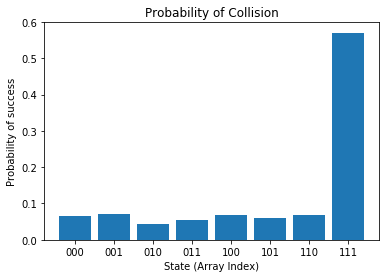

In [123]:
 specific_bht()

# Generalized BHT, on any array of size 8 w/ one collision  (n=3,N=8)

In [134]:
def pad(elt):
    length = len(elt)
    if length < 3:
        pads = 3-length
        for i in range(pads):
            elt = '0' + elt
    return elt


def int_to_bool_list(num):
   bin_string = format(num, '03b')
   return [x == '1' for x in bin_string]


def addC3not(circuit, control, t, ancilla):
    circuit.ccx(control[0], control[1], ancilla)
    circuit.ccx(control[2], ancilla, t)
    circuit.ccx(control[0], control[1], ancilla)


def addMapping(circuit, index, value, index_qubits, value_qubits, ancilla):
    index_bit_array = int_to_bool_list(index)
    value_bit_array = int_to_bool_list(value)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
    
    for (i, b) in enumerate(value_bit_array):
        if b:
            addC3not(circuit, index_qubits, value_qubits[i], ancilla)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
            
def addMappingBackward(circuit, index, value, index_qubits, value_qubits, ancilla):
    index_bit_array = int_to_bool_list(index)
    value_bit_array = int_to_bool_list(value)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
    
    for i in range(len(value_bit_array) - 1, -1, -1):
        if value_bit_array[i]:
            addC3not(circuit, index_qubits, value_qubits[i], ancilla)
    
    for (i, b) in enumerate(index_bit_array):
        if b == False:
            circuit.x(index_qubits[i])
    

def addC2Z(circuit, control, t):
    circuit.h(t)
    circuit.ccx(control[0], control[1], t)
    circuit.h(t)
        

def addGroverDiffusion(circuit, input_qubits):
    circuit.h(input_qubits[0])
    circuit.h(input_qubits[1])
    circuit.h(input_qubits[2])
    
    circuit.x(input_qubits[0])
    circuit.x(input_qubits[1])
    circuit.x(input_qubits[2])
    
    addC2Z(circuit, [input_qubits[0], input_qubits[1]],  input_qubits[2])
    
    circuit.x(input_qubits[0])
    circuit.x(input_qubits[1])
    circuit.x(input_qubits[2])
    
    circuit.h(input_qubits[0])
    circuit.h(input_qubits[1])
    circuit.h(input_qubits[2])


def x_to_f(circuit, control, target):
    circuit.cx(control[0],target[0])
    circuit.cx(control[1],target[1])
    

def set_F(circuit,control,target,ancilla):
    
    circuit.ccx(control[0],control[1],ancilla[0])
    circuit.ccx(control[1],control[2],ancilla[1])
    circuit.cx(control[2],target[2])
    circuit.ccx(ancilla[0],ancilla[1],target[2])
    
    x_to_f(circuit, control, target)
    
    circuit.ccx(control[1],control[2],ancilla[1]) # uncomputation, q[4] is reset and can be reused
    circuit.ccx(control[0],control[1],ancilla[0]) # uncomputation, q[3] is reset
       

def flip_inputs(circuit,bin_str, qubits):    
    # struture gate input (on X)
    for i, val in enumerate(bin_str):
        int_val = int(val)
        if int_val == 0:
            circuit.x(qubits[i]) # flip to 1
            
def generateFunctionBlackBox(circuit, array_to_use, index_qubits, value_qubits, ancilla):
    for (i, x) in enumerate(array_to_use):
        addMapping(circuit, i, x, index_qubits, value_qubits, ancilla)
        
def generateFunctionBlackBoxBackward(circuit, array_to_use, index_qubits, value_qubits, ancilla):
    for i in range(len(array_to_use) - 1 , -1, -1):
        addMappingBackward(circuit, i, array_to_use[i], index_qubits, value_qubits, ancilla)

                    
def generalized_grover(array_sample, L):

    iterations = 3
    
    # Setup QuantumProgram
    qp_uf = QuantumProgram()
    qp_uf.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url
    n = 10  # number of qubits
    q = qp_uf.create_quantum_register("q", n) # quantum register
    c = qp_uf.create_classical_register("c", n) # classical register
    grover = qp_uf.create_circuit("grover", [q], [c])
    
    grover.x(q[5])
    
    grover.h(q[0])
    grover.h(q[1])
    grover.h(q[2])
    grover.h(q[5])

    # Grovers Iteration
    for i in range(iterations):
        
        generateFunctionBlackBox(grover, array_sample, [q[0],q[1],q[2]],[q[7],q[8],q[9]], q[3])

        # Create H: X -> {1,0}, set q[5] as bool
        for x,f_x in L:
            fx = pad(str('{000:b}'.format(f_x)))
            x = pad(str('{000:b}'.format(x)))
            
            # 1. F(x) CHECK: if F = f(x) then q[7] = 1
            flip_inputs(grover,fx, [q[7],q[8],q[9]])
            grover.ccx(q[7],q[8],q[3])
            grover.ccx(q[9],q[3],q[4])
            
            grover.ccx(q[7],q[8],q[3]) # uncompute q[3]

            # 2. x CHECK: if x != x0 then q[7] = 1
            flip_inputs(grover,x, [q[0],q[1],q[2]])
            grover.ccx(q[0],q[1],q[3])
            grover.ccx(q[2],q[3],q[6]) # q[9] is the target. 1 if x0 = x1

            # focal: combine steps 1 and 2
            grover.x(q[6])
            grover.ccx(q[6], q[4], q[5])
            grover.x(q[6]) # uncomputation

            # Reset variables to init state (uncomputations)
            grover.ccx(q[2],q[3],q[6]) 
            grover.ccx(q[0],q[1],q[3])      
            flip_inputs(grover,x, [q[0],q[1],q[2]]) 
            grover.ccx(q[7],q[8],q[3]) # compute back
            grover.ccx(q[9],q[3],q[4]) 
            grover.ccx(q[7],q[8],q[3]) # uncomputation
            flip_inputs(grover,fx, [q[7],q[8],q[9]]) 
             
        # uncompute F, qubits 7,8,9
        generateFunctionBlackBoxBackward(grover, array_sample, [q[0],q[1],q[2]],[q[7],q[8],q[9]], q[3])

        # Grovers Diffusion Operator
        addGroverDiffusion(grover, [q[0], q[1], q[2]])
        
    #############
    # Measurement
    #############

    grover.measure(q[0], c[0]) 
    grover.measure(q[1], c[1]) 
    grover.measure(q[2], c[2]) 
    print("Gate Size: ", len(grover.data))

    #####################
    # Execute & Results
    #####################
    
    raw_qasm = qp_uf.get_qasm('grover')

    response = api.run_job([{'qasm': raw_qasm}], backend='ibmqx_qasm_simulator', shots=1024)
    
    return response
    


In [143]:
def generalized_bht(sample_array):    
    # X -> initial array to check for collision. List of indices
    X = [0,1,2,3,4,5,6,7]
    Y = sample_array

    # Initialize constants
    c = 1.18 # estimate by Brassard's paper
    k = int(c*np.sqrt(len(X))) # size of L

    # STEP 1 [classical]: arbitrary subset K and build table L

    K = random.sample(X, k)
    L = []

    # Compute values of L
    for i in range(len(K)):
        L.append((K[i],Y[X.index(K[i])]))

    # STEP 2 [classical]: sort L according to the second entry 
    L.sort(key=operator.itemgetter(1))

    # STEP 3 [classical]: attempt to find a collision in L
    collision = None
    for i in range(len(L)-1):
        next_x,next_f_x = L[i+1]
        x,f_x = L[i]

        if f_x == next_f_x:
            collision = (x,next_x)

    # print useful information
    print("Starting Generalized BHT - (n=3,N=8,iters=7)")
    print("X = ", X)
    print("Y = ", Y)
    print("k = ", k)
    print("L = ", L)
    print()
    if collision != None:
        print("Collision: ", collision)
    else:
        print("Collision not found classically, running Grover with 3 iterations")
        response = generalized_grover(sample_array, L) # Quantum
        
        result = {}
        while result == {} :
            executionId = response['qasms'][0]['executionId']
            result = api.get_result_from_execution(executionId)
        
        x = result['measure']['labels']
        y = result['measure']['values']

        for i in range(len(x)):
            label = x[i]
            x[i] = label[7:][::-1]
            
        plt.title("Probability of Collision")
        plt.xlabel("State (Array Index)")
        plt.ylabel("Probability of success")
        plt.bar(x,y)
        
        max_state = x[y.index(max(y))]
        print("Collision is most likely at: ", max_state)

Starting Generalized BHT - (n=3,N=8,iters=7)
X =  [0, 1, 2, 3, 4, 5, 6, 7]
Y =  [0, 1, 2, 3, 4, 5, 5, 6]
k =  3
L =  [(3, 3), (6, 5), (7, 6)]

Collision not found classically, running Grover with 3 iterations
Gate Size:  542
Collision is most likely at:  101


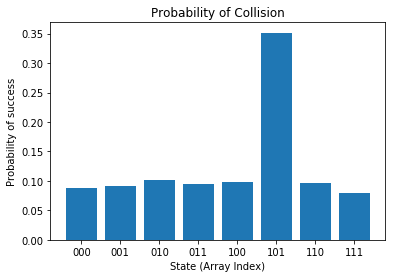

In [144]:
array_sample = [0, 1, 2, 3, 4, 5, 5, 6]
generalized_bht(array_sample)